### Importing Dependencies

In [214]:
import numpy as np
import matplotlib.pyplot as plt
import keras

In [215]:
import pickle

def load_set(directory):
    try:
        with open(f"{directory}/texts.pkl", "rb") as fp:
            processed_texts = pickle.load(fp)
        
        with open(f"{directory}/labels.pkl", "rb") as fp:
            labels = pickle.load(fp)
    
    except:
        print(f'{directory} files not found. Please run the preprocess.ipynb before!')
    
    return processed_texts, labels

In [216]:
processed_texts, labels = load_set('train')
processed_val_texts, val_labels = load_set('val')
processed_test_texts, test_labels = load_set('test')

In [217]:
processed_texts[:5]

['need advice appreciate people will will super aggressive control 6 month ago cheat girlfriend tell shortly feel like shit remind come get bad want stay thought linger way closure come thank advance hope y’ hate',
 'dear Magic Eye Bot hate wanna T',
 'teacher sub right wrong answer assignment clearly personal choice',
 'officially close 30 year age 10 goodbye r teenager fun today reach age subreddit long target good thing care cause mind 12',
 'sure royal family racism thing interesting you hear conspiracy kidnap child own cult shit wild surprised queen live']

In [218]:
lengths = [len(processed_text) for processed_text in processed_texts if len(processed_text) < 2000]

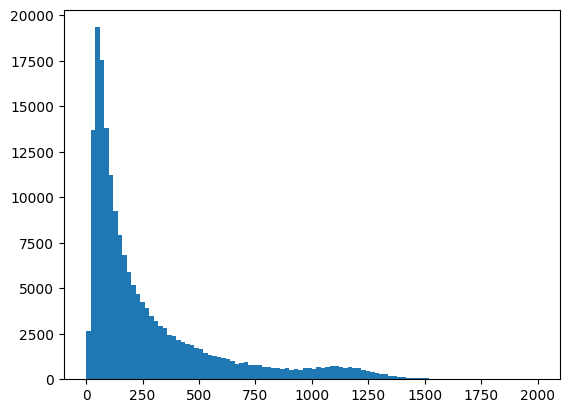

In [219]:
plt.hist(lengths, bins=100)
plt.show()

### Creating the Model

#### Vectorization

In [220]:
TextVectorization = keras.layers.TextVectorization

vectorize_layer = TextVectorization(
    max_tokens=3000,
    output_mode='int',
    output_sequence_length=200,
)

vectorize_layer.adapt(processed_texts + processed_val_texts)

In [221]:
vectorized_texts = vectorize_layer(processed_texts)

In [222]:
vectorized_val_texts = vectorize_layer(processed_val_texts)

#### Model 1

In [223]:
Sequential = keras.models.Sequential
from keras_tuner import HyperParameters as hp
from keras_tuner import RandomSearch

# def build_model(hp):
#     """Base Model Bidirectional Layer LSTM cells with return sequence"""
#     model = Sequential()
#     model.add(keras.layers.Embedding(3000,16))
#     for i in range(hp.Int('layers', 2,5)):
#         keras.layers.Bidirectional(keras.layers.LSTM(units = hp.Int('units_' + str(i), min_value=10, max_value=30, step=10))),
#     model.add(keras.layers.Dense(1, activation = hp.Choice('activation_' + str(i), ['sigmoid', 'softmax', 'hard_sigmoid', 'elu', 'leaky_relu'])))

#     model.compile(
#         loss='binary_crossentropy',
#         optimizer='adam',
#         metrics=['accuracy']
#     )
#     return model

def build_model(hp):
    """Base Model Bidirectional Layer LSTM cells"""
    model = Sequential([
            keras.layers.Embedding(3000, 16),
        keras.layers.Bidirectional(keras.layers.LSTM(units = hp.Int('units', min_value=10, max_value=100, step=10), return_sequences=True)),
        keras.layers.Bidirectional(keras.layers.LSTM(units = hp.Int('units', min_value=10, max_value=100, step=10))),
        keras.layers.Dense(1, activation = hp.Choice('activation', ['sigmoid', 'hard_sigmoid', 'elu', 'leaky_relu']))
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model

In [224]:
tuner = RandomSearch(
	build_model,
	objective='val_accuracy',
	max_trials=5,
	executions_per_trial=3,
	directory='../runs',
	project_name='tuner1'
)

tuner.search_space_summary()

Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 100, 'step': 10, 'sampling': 'linear'}
activation (Choice)
{'default': 'sigmoid', 'conditions': [], 'values': ['sigmoid', 'hard_sigmoid', 'elu', 'leaky_relu'], 'ordered': False}


In [225]:
tuner.search(vectorized_texts, labels, epochs=10, validation_data=(vectorized_val_texts, val_labels), callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
    ])

Trial 2 Complete [02h 12m 02s]
val_accuracy: 0.6451510985692342

Best val_accuracy So Far: 0.9366454084714254
Total elapsed time: 03h 51m 57s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
100               |10                |units
hard_sigmoid      |leaky_relu        |activation

Epoch 1/10
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.8717 - loss: 0.3412

##### Tuner Results

In [ ]:
# Bidirectional, LSTM
tuner.results_summary()

##### Evaluating the Model

In [ ]:
vectorized_test_texts = vectorize_layer(processed_test_texts)

In [ ]:
best_model = tuner.get_best_models(num_models=3)

In [ ]:
best_model = best_model[0] # You can decide which model to look at

In [ ]:
best_model.summary()
_ = best_model.evaluate(vectorized_test_texts, test_labels)

In [ ]:
y_pred = best_model.predict(vectorized_test_texts)
y_pred = (y_pred > 0.5).astype(int)
y_pred = np.array(list(map(lambda x: x[0], y_pred)))

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

tn, fp, fn, tp = confusion_matrix(test_labels, y_pred).ravel()

fpr = fp / (fp + tn)
print(f"False Positive Rate: {fpr:.4f}")

fnr = fn / (fn + tp)
print(f"False Negative Rate: {fnr:.4f}")

print(f'accuracy_score {accuracy_score(test_labels, y_pred):.3f}')
print(f'precision_score {precision_score(test_labels, y_pred):.3f}')
print(f'recall_score {recall_score(test_labels, y_pred):.3f}')
print(f'f1_score {f1_score(test_labels, y_pred):.3f}')

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

ConfusionMatrixDisplay.from_predictions(test_labels, y_pred, normalize="true",
                                        values_format=".0%")
plt.show()